# Experiment 5

In [1]:
import time

import pandas as pd
import numpy as np

import quantstats as qs

from tinycta.port import build_portfolio
from tinycta.linalg import *
from tinycta.signal import *

In [ ]:
#from datetime import datetime
#custom_date_parser = lambda x: datetime.strptime(x, "%d.%m.%Y")
#df = pd.read_csv('data/futures_prices.csv',
#                 parse_dates=[0],
#                date_parser=custom_date_parser, index_col=0)

#df.columns = {str(abs(hash(column))) for column in df.columns}
#df.to_csv('data/p_hashed.csv')

In [2]:
# Load prices
prices = pd.read_csv("data/Prices_hashed.csv", index_col=0, parse_dates=True).ffill()

In [3]:
from ipywidgets import Label, HBox, VBox, IntSlider, FloatSlider

fast = IntSlider(min=4, max=192, step=4, value=32)
slow = IntSlider(min=4, max=192, step=4, value=96)
vola = IntSlider(min=4, max=192, step=4, value=32)
winsor = FloatSlider(min=1.0, max=6.0, step=0.1, value=4.2)
corr = IntSlider(min=50, max=500, step=10, value=200)
shrinkage = FloatSlider(min=0.0, max=1.0, step=0.05, value=0.5)
left_box = VBox([Label("Fast Moving Average"), 
                 Label("Slow Moving Average"), 
                 Label("Volatility"), 
                 Label("Winsorizing"),
                 Label("Correlation"),
                 Label("Shrinkage")])

right_box = VBox([fast, slow, vola, winsor, corr, shrinkage])
HBox([left_box, right_box])

In [4]:
T = time.time()
correlation = corr.value

# this is a lot faster than Pandas...
position = np.nan*np.zeros_like(prices.values)

returns_adj = prices.apply(returns_adjust, com=vola.value, clip=winsor.value)
# DCC by Engle
cor = returns_adj.ewm(com=corr.value, min_periods=corr.value).corr()

mu = np.tanh(returns_adj.cumsum().apply(osc)).values
vo = prices.pct_change().ewm(com=vola.value, min_periods=vola.value).std().values

for n,t in enumerate(prices.index):
    matrix = shrink2id(cor.loc[t].values, lamb=shrinkage.value)
    risk_position = solve(matrix, mu[n])/inv_a_norm(mu[n], matrix)
    position[n] = risk_position/vo[n]

portfolio = build_portfolio(prices, 1e6*pd.DataFrame(index=prices.index, columns=prices.keys(), data=position))
print(time.time()-T)


/Users/a13069q/github/cs/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


4.922030210494995


<Axes: >

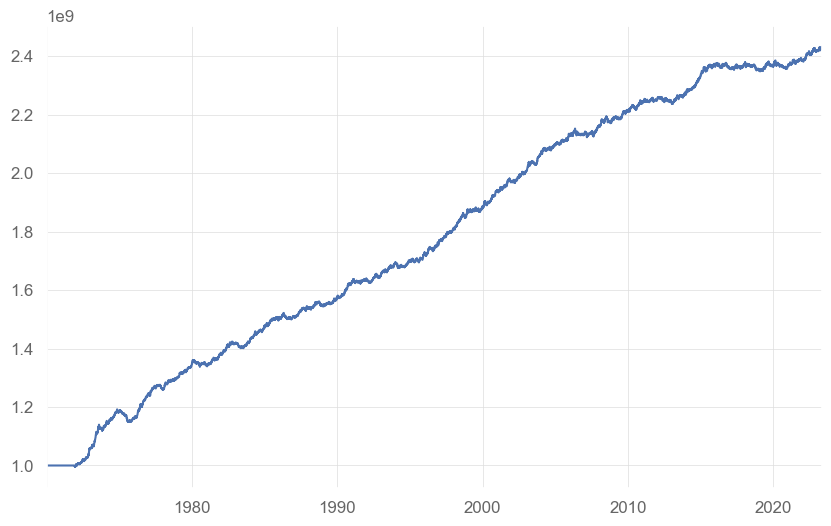

In [5]:
capital = 1e9
a = portfolio.nav(aum=capital)
a.plot()

# Conclusions
* Dramatic relativ improvements observable despite using the same signals as in previous Experiment.
* Main difference here is to take advantage of cross-correlations in the risk measurement.
* Possible to add constraints on individual assets or groups of them.
* Possible to reflect trading costs in objective with regularization terms (Ridge, Lars, Elastic Nets, ...)

                    Strategy
------------------  ----------
Start Period        1970-01-02
End Period          2023-04-26
Risk-Free Rate      0.0%
Time in Market      95.0%

Cumulative Return   143.07%
CAGR﹪              1.16%

Sharpe              1.49
Prob. Sharpe Ratio  100.0%
Sortino             2.26
Sortino/√2          1.6
Omega               1.29

Max Drawdown        -3.58%
Longest DD Days     584

Gain/Pain Ratio     0.29
Gain/Pain (1M)      1.98

Payoff Ratio        1.04
Profit Factor       1.29
Common Sense Ratio  1.42
CPC Index           0.74
Tail Ratio          1.1
Outlier Win Ratio   3.69
Outlier Loss Ratio  3.26

MTD                 0.23%
3M                  0.58%
6M                  0.19%
YTD                 0.48%
1Y                  1.04%
3Y (ann.)           0.59%
5Y (ann.)           0.38%
10Y (ann.)          0.52%
All-time (ann.)     1.16%

Avg. Drawdown       -0.2%
Avg. Drawdown Days  25
Recovery Factor     24.93
Ulcer Index         0.01
Serenity Index      9.23


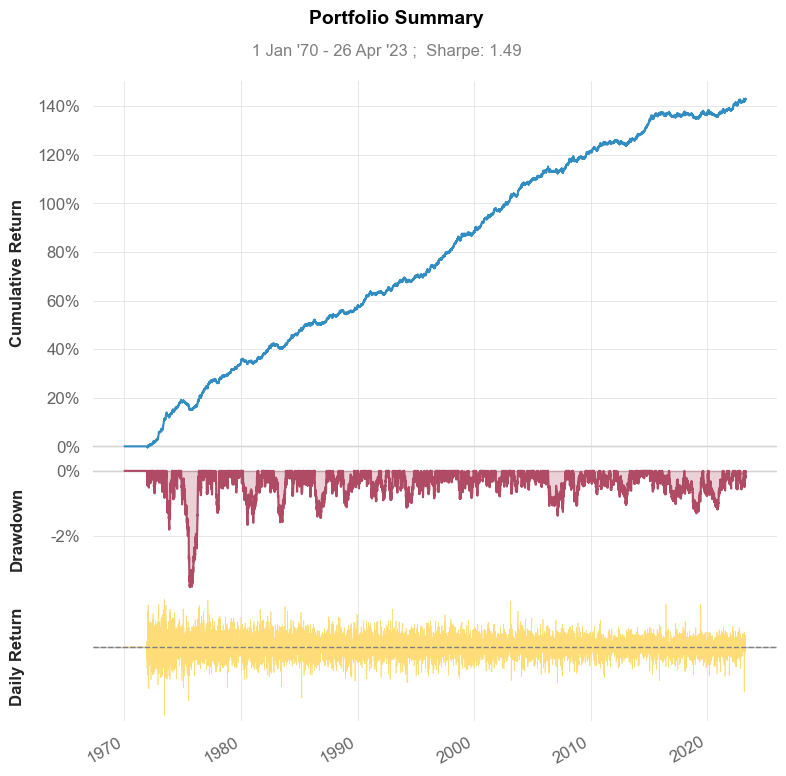

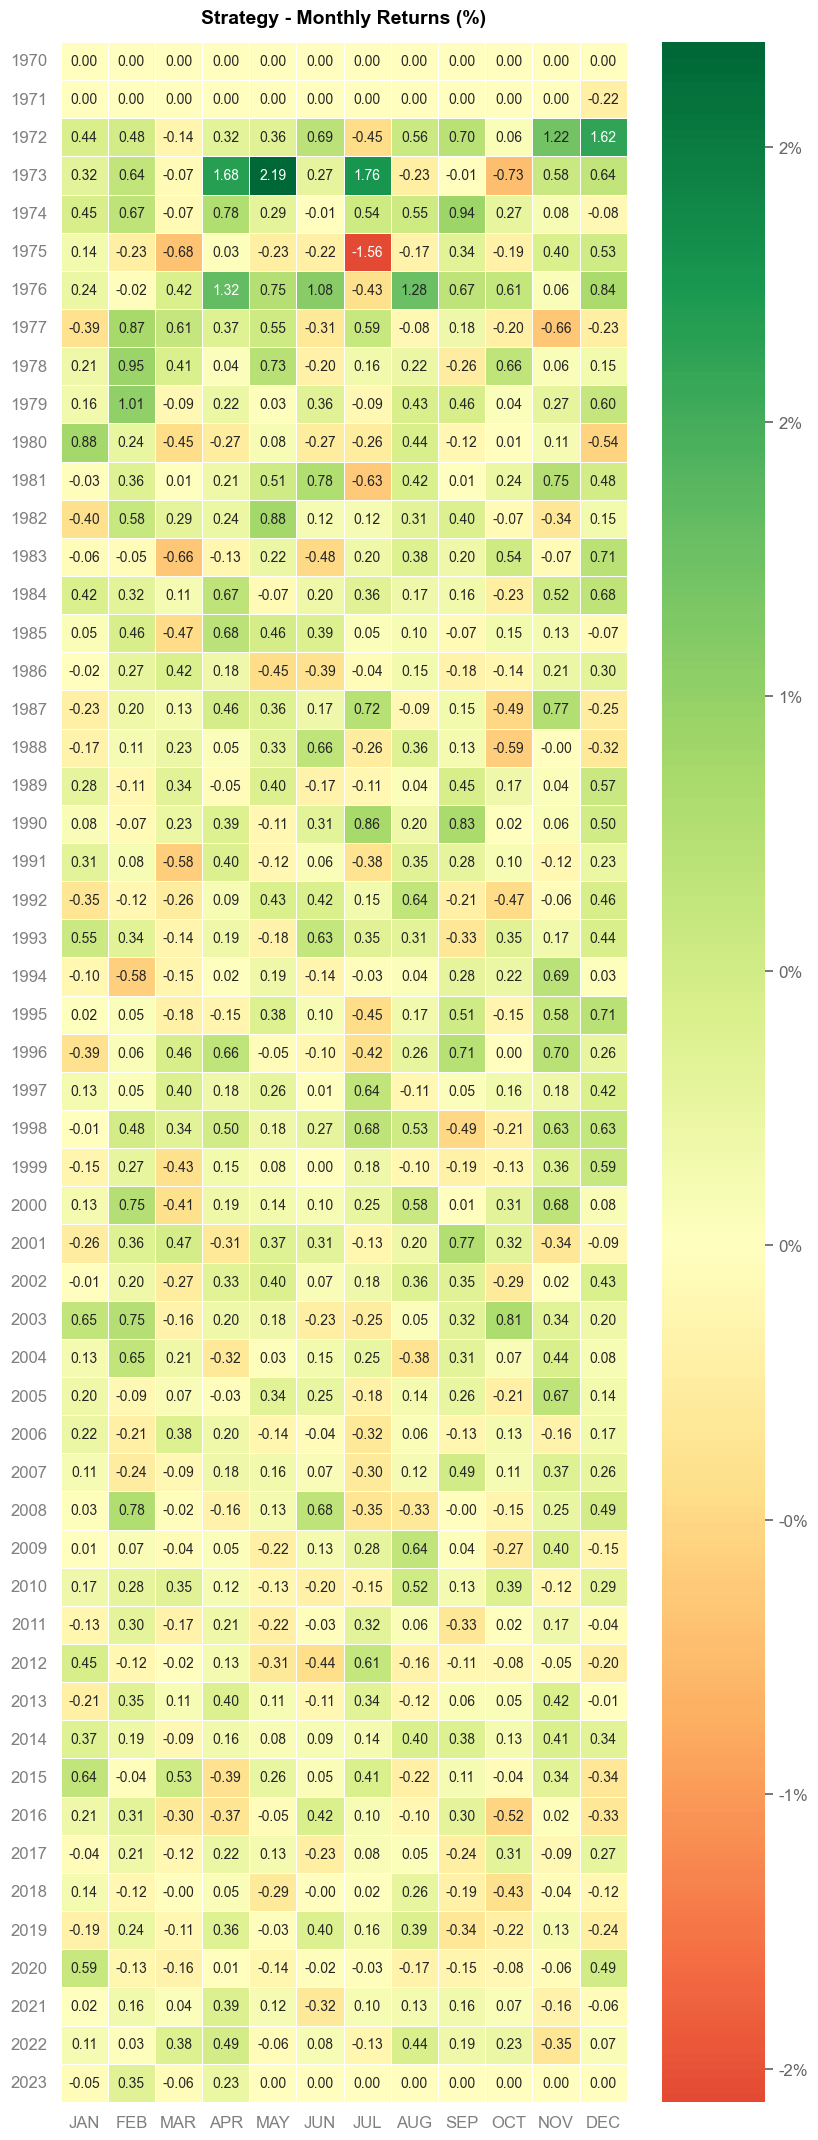

In [6]:
qs.reports.basic(a)